# Test of Greg Kamradt's semantic chunking for Chinese

In [1]:
with open('../../../text_files/your_cat_part_3.txt') as file:
    essay = file.read()

### Single-pattern split

In [104]:
import re
pattern = r'(?<=[。？；!])\s*|(?<=\.)\s*\n'
single_sentences_list = re.split(pattern, essay)
print(f"{len(single_sentences_list)} senteneces were found")
print(f"max length of sentence: {max(len(sentence) for sentence in single_sentences_list)}")

1455 senteneces were found
max length of sentence: 160


### Multi-patterns split

In [105]:
import re

pattern1 = r'={16}'
pattern2 = r'(?<=[。？；!])\s*|(?<=\.)\s*\n'
patterns = [pattern1, pattern2]

def split_by_patterns(text, patterns):
    result = [text]
    for pattern in patterns:
        temp = []
        for segment in result:
            temp.extend(re.split(pattern, segment))
        result = temp
    return result


In [106]:
single_sentences_list = split_by_patterns(essay, patterns)

In [107]:
print(f"{len(single_sentences_list)} senteneces were found")
print(f"max length of sentence: {max(len(sentence) for sentence in single_sentences_list)}")

1455 senteneces were found
max length of sentence: 160


In [108]:
# print(single_sentences_list[0:5])
for i, sentence in enumerate(single_sentences_list[:5]):
    print(f"sentence {i}: {sentence}")

sentence 0: 【第三部】

年輕成貓的燦爛時光

貓長大了—該餵什麼食物?
小貓現在長大了,你可能在想是不是該做些什麼改變,好讓你這位
進入成年期的特別朋友跟幼貓期一樣健康。
sentence 1: 當然你得帶貓去結紮
如果你還沒有這麼做。
sentence 2: 每年還要帶貓去給獸醫做一次健康檢查。
sentence 3: 你可能會
覺得或許這個階段,食物也該做一些調整,但其實沒有必要。
sentence 4: 野生的幼貓
長大後還是獵捕相同的獵物,所以你的年輕成貓只要繼續吃幼貓期吃的高
蛋白質、低碳水化合物的食物即可。


In [74]:
sentences = [{'sentence': x, 'index' : i} for i, x in enumerate(single_sentences_list)]

### function for combine sentences into group
ex: group1: 1,2,3; group2: 2,3,4; group3: 3,4,5...
buffer_size is the group size

In [75]:
def combine_sentences(sentences, buffer_size=1):
    # Go through each sentence dict
    for i in range(len(sentences)):

        # Create a string that will hold the sentences which are joined
        combined_sentence = ''

        # Add sentences before the current one, based on the buffer size.
        for j in range(i - buffer_size, i):
            # Check if the index j is not negative (to avoid index out of range like on the first one)
            if j >= 0:
                # Add the sentence at index j to the combined_sentence string
                combined_sentence += sentences[j]['sentence'] + ' '

        # Add the current sentence
        combined_sentence += sentences[i]['sentence']

        # Add sentences after the current one, based on the buffer size
        for j in range(i + 1, i + 1 + buffer_size):
            # Check if the index j is within the range of the sentences list
            if j < len(sentences):
                # Add the sentence at index j to the combined_sentence string
                combined_sentence += ' ' + sentences[j]['sentence']

        # Then add the whole thing to your dict
        # Store the combined sentence in the current sentence dict
        sentences[i]['combined_sentence'] = combined_sentence

    return sentences



In [76]:
sentences = combine_sentences(sentences)

In [77]:
sentences[0:3]

[{'sentence': '【第三部】\n\n年輕成貓的燦爛時光\n\n貓長大了—該餵什麼食物?\n小貓現在長大了,你可能在想是不是該做些什麼改變,好讓你這位\n進入成年期的特別朋友跟幼貓期一樣健康。',
  'index': 0,
  'combined_sentence': '【第三部】\n\n年輕成貓的燦爛時光\n\n貓長大了—該餵什麼食物?\n小貓現在長大了,你可能在想是不是該做些什麼改變,好讓你這位\n進入成年期的特別朋友跟幼貓期一樣健康。 當然你得帶貓去結紮\n如果你還沒有這麼做。'},
 {'sentence': '當然你得帶貓去結紮\n如果你還沒有這麼做。',
  'index': 1,
  'combined_sentence': '【第三部】\n\n年輕成貓的燦爛時光\n\n貓長大了—該餵什麼食物?\n小貓現在長大了,你可能在想是不是該做些什麼改變,好讓你這位\n進入成年期的特別朋友跟幼貓期一樣健康。 當然你得帶貓去結紮\n如果你還沒有這麼做。 每年還要帶貓去給獸醫做一次健康檢查。'},
 {'sentence': '每年還要帶貓去給獸醫做一次健康檢查。',
  'index': 2,
  'combined_sentence': '當然你得帶貓去結紮\n如果你還沒有這麼做。 每年還要帶貓去給獸醫做一次健康檢查。 你可能會\n覺得或許這個階段,食物也該做一些調整,但其實沒有必要。'}]

In [78]:
from langchain_community.embeddings.huggingface import HuggingFaceEmbeddings

embedding = HuggingFaceEmbeddings(
        model_name="aspire/acge_text_embedding",
        model_kwargs={'device': 'cpu'},
        show_progress=True
        )

In [79]:
embeddings = embedding.embed_documents([x['combined_sentence'] for x in sentences])

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

In [81]:
for i, sentence in enumerate(sentences):
    sentence['combined_sentence_embedding'] = embeddings[i]
print(len(sentences[0].get("combined_sentence_embedding")))

1792


### calculate cosine similarity

In [82]:
from sklearn.metrics.pairwise import cosine_similarity

def calculate_cosine_distances(sentences):
    distances = []
    for i in range(len(sentences) - 1):
        embedding_current = sentences[i]['combined_sentence_embedding']
        embedding_next = sentences[i + 1]['combined_sentence_embedding']
        
        # Calculate cosine similarity
        similarity = cosine_similarity([embedding_current], [embedding_next])[0][0]
        
        # Convert to cosine distance, 0 means the sentences are identical, 1 means they are unrelated, 2 means they are opposite
        distance = 1 - similarity

        # Append cosine distance to the list
        distances.append(distance)

        # Store distance in the dictionary
        sentences[i]['distance_to_next'] = distance

    # Optionally handle the last sentence
    # sentences[-1]['distance_to_next'] = None  # or a default value

    return distances, sentences

In [83]:
distances, sentences = calculate_cosine_distances(sentences)

In [84]:
distances[:3]

[0.003798265092104236, 0.30041905407555114, 0.2229516669924121]

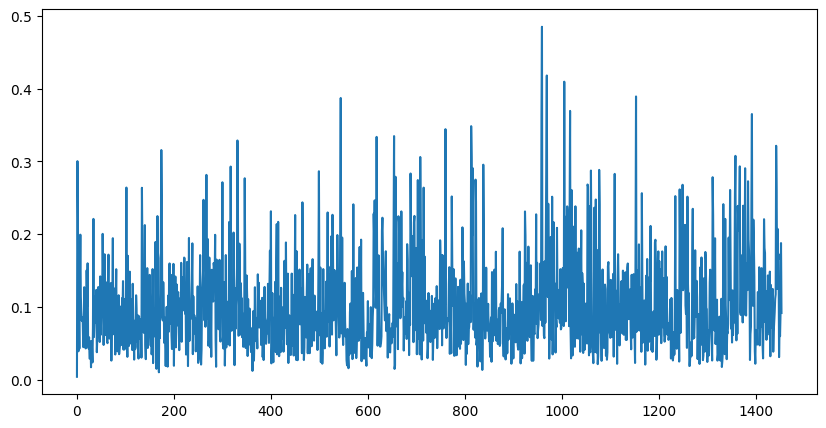

In [85]:
import matplotlib.pyplot as plt

# plt.plot(distances)
fig, ax = plt.subplots(figsize=(10, 5))  # 设置宽度为10英寸，高度为5英寸

# 绘制数据
ax.plot(distances)

95% threshold: 0.18825921352661334


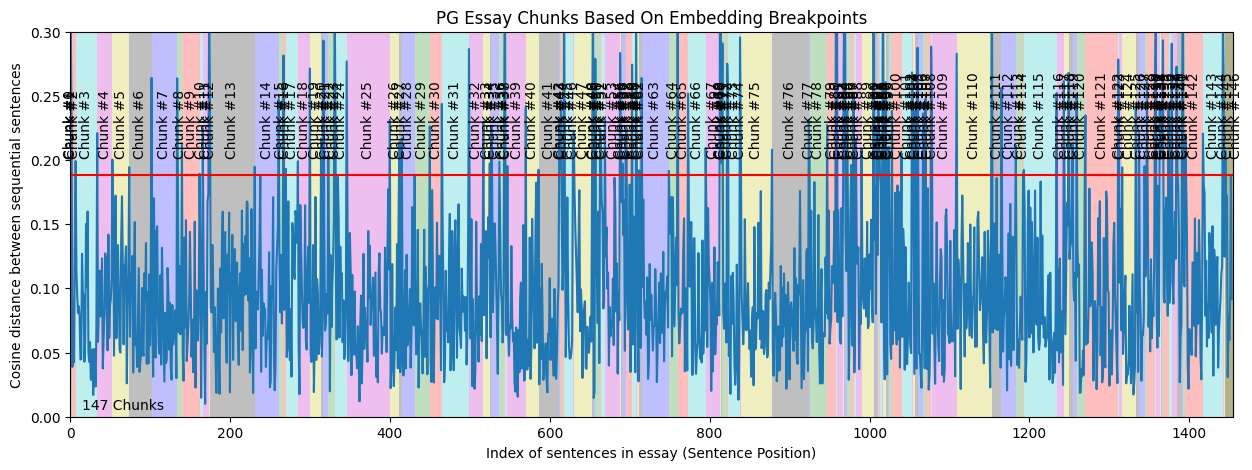

In [91]:
import numpy as np

fig, ax = plt.subplots(figsize=(15, 5))  # 设置宽度为10英寸，高度为5英寸
ax.plot(distances)
# plt.plot(distances)

y_upper_bound = .3
plt.ylim(0, y_upper_bound)
plt.xlim(0, len(distances))

# We need to get the distance threshold that we'll consider an outlier
# We'll use numpy .percentile() for this
breakpoint_percentile_threshold = 90
breakpoint_distance_threshold = np.percentile(distances, breakpoint_percentile_threshold) # If you want more chunks, lower the percentile cutoff
print(f"95% threshold: {breakpoint_distance_threshold}")
plt.axhline(y=breakpoint_distance_threshold, color='r', linestyle='-')

# Then we'll see how many distances are actually above this one
num_distances_above_theshold = len([x for x in distances if x > breakpoint_distance_threshold]) # The amount of distances above your threshold
plt.text(x=(len(distances)*.01), y=y_upper_bound/50, s=f"{num_distances_above_theshold + 1} Chunks")

# Then we'll get the index of the distances that are above the threshold. This will tell us where we should split our text
indices_above_thresh = [i for i, x in enumerate(distances) if x > breakpoint_distance_threshold] # The indices of those breakpoints on your list

# Start of the shading and text
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for i, breakpoint_index in enumerate(indices_above_thresh):
    start_index = 0 if i == 0 else indices_above_thresh[i - 1]
    end_index = breakpoint_index if i < len(indices_above_thresh) - 1 else len(distances)

    plt.axvspan(start_index, end_index, facecolor=colors[i % len(colors)], alpha=0.25)
    plt.text(x=np.average([start_index, end_index]),
             y=breakpoint_distance_threshold + (y_upper_bound)/ 20,
             s=f"Chunk #{i}", horizontalalignment='center',
             rotation='vertical')

# # Additional step to shade from the last breakpoint to the end of the dataset
if indices_above_thresh:
    last_breakpoint = indices_above_thresh[-1]
    if last_breakpoint < len(distances):
        plt.axvspan(last_breakpoint, len(distances), facecolor=colors[len(indices_above_thresh) % len(colors)], alpha=0.25)
        plt.text(x=np.average([last_breakpoint, len(distances)]),
                 y=breakpoint_distance_threshold + (y_upper_bound)/ 20,
                 s=f"Chunk #{i+1}",
                 rotation='vertical')

plt.title("PG Essay Chunks Based On Embedding Breakpoints")
plt.xlabel("Index of sentences in essay (Sentence Position)")
plt.ylabel("Cosine distance between sequential sentences")
plt.show()

## Chunking by breakpoint_index

In [92]:
# Initialize the start index
start_index = 0

# Create a list to hold the grouped sentences
chunks = []

# Iterate through the breakpoints to slice the sentences
for index in indices_above_thresh:
    # The end index is the current breakpoint
    end_index = index

    # Slice the sentence_dicts from the current start index to the end index
    group = sentences[start_index:end_index + 1]
    combined_text = ' '.join([d['sentence'] for d in group])
    chunks.append(combined_text)
    
    # Update the start index for the next group
    start_index = index + 1

# The last group, if any sentences remain
if start_index < len(sentences):
    combined_text = ' '.join([d['sentence'] for d in sentences[start_index:]])
    chunks.append(combined_text)

# grouped_sentences now contains the chunked sentences

In [98]:
print(f"Number of chunks: {len(chunks)}")
print(f"Max length:{max(len(chunk) for chunk in chunks)}")
for chunk in chunks:
    print(len(chunk))

Number of chunks: 147
Max length:2452
101
18
258
1180
995
608
1110
1226
231
967
163
352
30
2301
1706
269
115
704
858
660
150
218
206
22
653
2452
536
109
561
729
508
1435
815
233
107
325
133
10
55
870
641
1110
25
40
84
359
24
797
19
144
150
11
175
804
21
56
117
21
268
172
11
140
99
1478
319
499
1063
678
40
14
22
243
33
618
38
1614
2033
58
1042
329
33
337
53
14
112
116
125
127
303
596
143
89
41
17
54
25
135
109
33
151
430
497
43
107
226
302
120
275
27
1437
2052
510
895
492
24
1815
409
193
92
150
393
1770
19
151
565
167
407
161
348
17
180
52
52
16
19
209
104
189
31
190
25
111
884
847
32
51
351


## show chunks

In [35]:
# for i, chunk in enumerate(chunks[:4]):
#     buffer = 100
    
#     print (f"Chunk #{i} ###############################")
#     print (chunk[:buffer].strip())
#     print ("...")
#     print (chunk[-buffer:].strip())
#     print ("\n")

In [95]:
for i, chunk in enumerate(chunks):
    print (f"Chunk #{i} ########################################################")
    print (chunk)

Chunk #0 ########################################################
【第三部】

年輕成貓的燦爛時光

貓長大了—該餵什麼食物?
小貓現在長大了,你可能在想是不是該做些什麼改變,好讓你這位
進入成年期的特別朋友跟幼貓期一樣健康。 當然你得帶貓去結紮
如果你還沒有這麼做。
Chunk #1 ########################################################
每年還要帶貓去給獸醫做一次健康檢查。
Chunk #2 ########################################################
你可能會
覺得或許這個階段,食物也該做一些調整,但其實沒有必要。 野生的幼貓
長大後還是獵捕相同的獵物,所以你的年輕成貓只要繼續吃幼貓期吃的高
蛋白質、低碳水化合物的食物即可。 如果你目前是餵貓吃乾飼料,那麼該
是轉吃健康食物的時候,以確保健康的貓生。 生命階段概念的謬誤
多年來,寵物食品公司以「生命階段」為概念,行銷他們製造的乾
飼料和罐頭。 根據這套理論,幼貓需要特定的營養成分(包括蛋白質、
脂肪、碳水化合物、維他命和礦物質),成貓需要不一樣的營養成分,
而老貓又是另一套不同的營養成分,以維持最佳健康狀態。
Chunk #3 ########################################################
這個概念被
廣為接受,或者至少沒有遭遇到獸醫營養專家的反對。 如此被廣為接受
是一件令人很意外的事,因為在貓食和貓本身的特性上,你可以看到許
多明顯的矛盾之處。 在野外,不管是小型還是大型貓科動物,都沒有隨著年紀的增加而
改變食物中的營養成分。 所有貓科動物一旦斷奶之後,便跟著吃成貓捕
獲的獵物,例如小型哺乳動物、鳥、蜥蜴、鳥蛋、昆蟲,諸如此類。 幼
貓跟著成貓一起吃,或者吃成貓吃剩的。 在貓的一生中,年輕貓和老貓
捕獲而吃下的獵物並沒有什麼不同。 貓的食物確實會隨著時間的過去而
轉變,不過那是環境中可供選擇的獵物增加或減少的緣故,跟貓年紀完
全無關。 我們知道幼貓自然吃下的養分,和成貓的食物養分是完全一樣的。 畢竟,不管是被年輕貓或老貓抓到而吃下,一隻老鼠或一隻鳥或一隻蜥
蜴,養分都是一樣的。 和成貓